In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude

from discrete_time_extrusion.Translocator import Translocator

from discrete_time_extrusion.extruders.BaseExtruder import BaseExtruder
from discrete_time_extrusion.extruders.BaseExtruder import BaseExtruder

from discrete_time_extrusion.boundaries.StaticBoundary import StaticBoundary

from polykit.generators.initial_conformations import grow_cubic


In [2]:
# Initialise HOOMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 4546


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [20000, 10000]

In [6]:
# Confine chromosomes within a sphere of appropriate radius
number_of_monomers = sum(chromosome_sizes)
confinement_radius = (3*number_of_monomers / (4*np.pi*density))**(1/3.)

In [7]:
# Set simulation box large enough to accomodate the chromosomes
snapshot = build.get_simulation_box(box_length=2*confinement_radius, pad=1.)

In [8]:
# Build random, dense initial conformations
inscribed_cube_length = confinement_radius*2/3**.5
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(inscribed_cube_length))

In [9]:
# Parse force parameters
with open("../data/force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

In [10]:
# Parse particle/bond types
bond_types = force_dict['Bonded forces'].keys()
angle_types = force_dict['Angular forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()

In [11]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes,
                      bond_type_list=list(bond_types), monomer_type_list=list(monomer_types),
                      angle_type_list=list(angle_types))

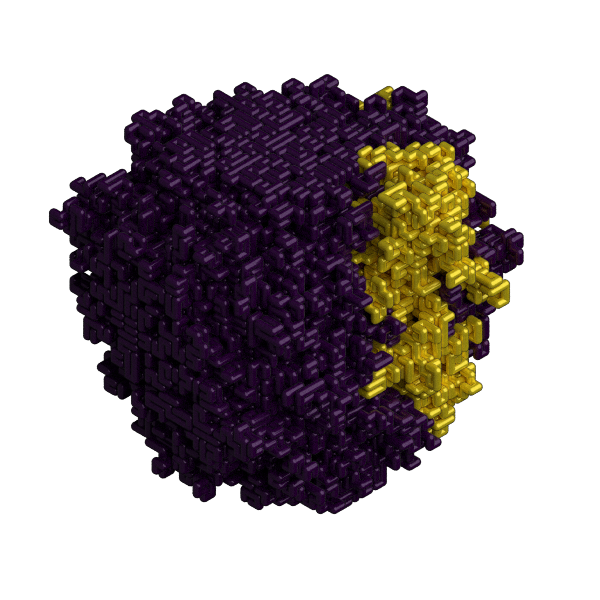

In [12]:
# Render individual chromosomes using the Fresnel backend
render.fresnel(snapshot, show="chromosomes").static()

In [13]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

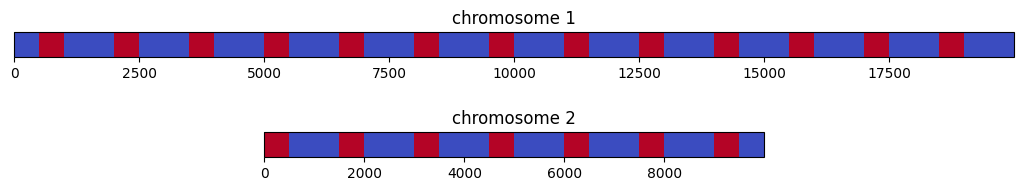

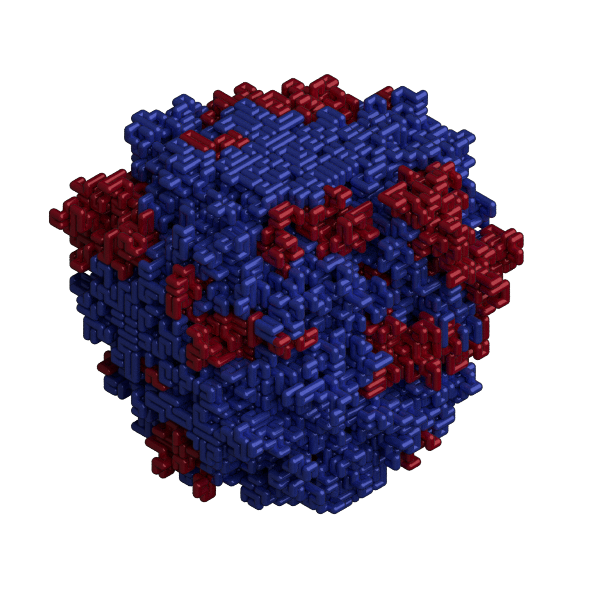

In [14]:
# Assign and visualize domains in 1D/3D
snapshot.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot, cmap="coolwarm")
render.fresnel(snapshot, show="compartments", cmap="coolwarm").static()

In [15]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [16]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.2)

In [17]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [18]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [19]:
# Set spherical confining wall
force_dict['External forces']['Confinement']['Spherical'] = dict(R=confinement_radius)
confinement_forces = forces.get_confinement_forces(**force_dict)

In [20]:
# Set attractive/DPD forces
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

Setting up DPD with the conservative force contribution disabled


In [21]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces + confinement_forces \
            + dpd_forces + attraction_forces

In [22]:
# Setup DPD integrator
nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/test3/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [23]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [24]:
# Run
system.run(1e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           3331.18228     0:00:27.017435           0.96041          
       20000           4213.75510     0:00:18.985441           1.00924          
       30000           4615.73140     0:00:15.165527           1.02482          
       40000           4834.26808     0:00:12.411393           1.02294          
       50000           4972.88431     0:00:10.054527           1.02655          
       60000           5074.26780     0:00:07.882911           1.03594          
       70000           5149.24339     0:00:05.826099           1.03587          
       80000           5201.84077     0:00:03.844793           1.03322          
       90000           5244.04605     0:00:01.906925           1.02875          
      100000           5277.21041        0:00:00               1.02178          


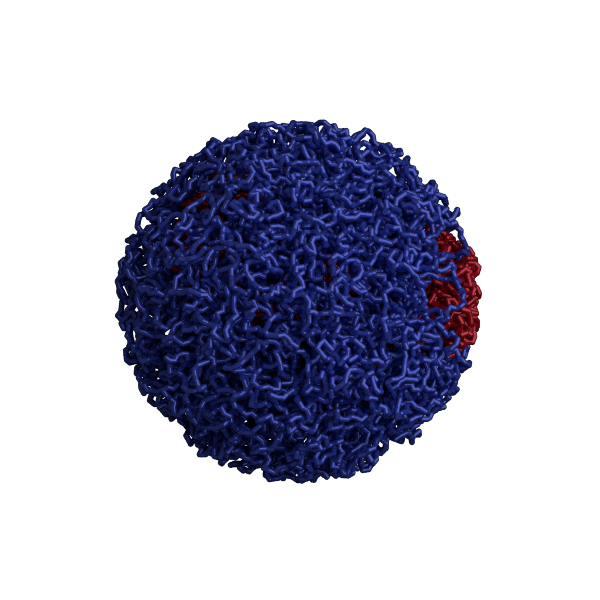

In [25]:
# Visualize equilibrated domains in 3D
snapshot_equilibrated = system.state.get_snapshot()
render.fresnel(snapshot_equilibrated, show="compartments", cmap="coolwarm").static()

In [26]:
# Parse extrusion parameters
with open("../data/extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)

In [27]:
# Create some CTCF boundary sites
tad_size = 100 # in monomers

ctcf_left_positions = np.arange(0, number_of_monomers, tad_size)
ctcf_right_positions = np.arange(0, number_of_monomers, tad_size)

In [28]:
# Create translocator object
translocator = Translocator(BaseExtruder,
                            StaticBoundary,
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions,
                            device='GPU',
                            **extrusion_dict)

In [29]:
# Precompute extruder positions
translocator.run(translocator.params['dummy_steps'])

extrude.update_topology(system, translocator.extrusion_engine.positions)

/home1/tortora/.conda/envs/test3/lib/python3.10/site-packages/discrete_time_extrusion/extruders/EngineFactory.py:44: UserWarning: Running lattice extrusion on the GPU
  warnings.warn("Running lattice extrusion on the GPU")
/home1/tortora/endeavour/polychrom-hoomd/polychrom_hoomd/extrude.py:50: UserWarning: Unable to dynamically resize bond arrays on the GPU - reverting to non-local topology update
  warnings.warn("%s - reverting to non-local topology update" % e)


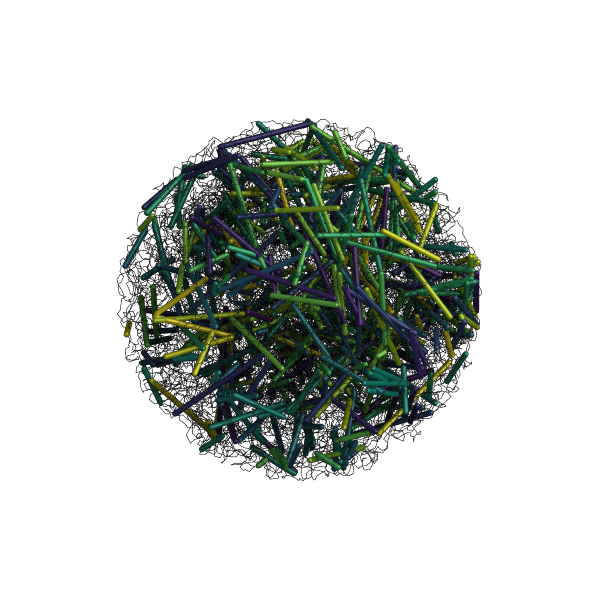

In [30]:
# Visualize new extrusion bonds 
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show="loops", rescale_backbone_bonds=0.1).static()

In [31]:
# Define relaxation force field
relax_field = repulsion_forces + bonded_forces + confinement_forces

In [32]:
# Relax CTCF bonds via the fast inertial relaxation engine
system.operations.remove(dpd_integrator)
system.operations.remove(system.operations.writers[0])

fire = hoomd.md.minimize.FIRE(dt=1e-2, methods=[nve], forces=relax_field,
                              force_tol=5e-2, angmom_tol=5e-2, energy_tol=5e-2)

In [33]:
# Update simulation engine
system.operations.integrator = fire
system.operations.writers.append(log.table_formatter(logger, period=500))

In [34]:
# Run
system.run(5e3)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      100500           171.37343      0:00:26.258447           0.09509          
      101000           307.92685      0:00:12.990098           0.00177          
      101500           453.07993      0:00:07.724906           0.00004          
      102000           603.97603      0:00:04.967085           0.00004          
      102500           754.78970      0:00:03.312181           0.00004          
      103000           905.56872      0:00:02.208557           0.00004          
      103500           1056.19667     0:00:01.420190           0.00004          
      104000           1206.80737     0:00:00.828633           0.00004          
      104500           1357.24547     0:00:00.368393           0.00004          
      105000           1507.68652        0:00:00               0.00004          


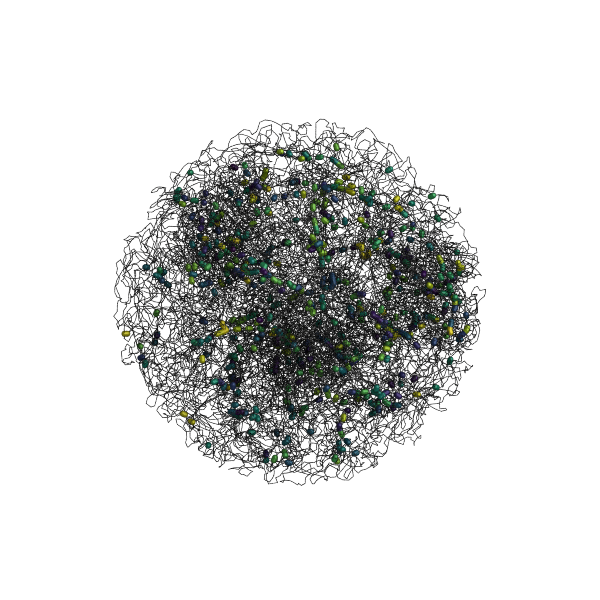

In [35]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show="loops", rescale_backbone_bonds=0.1).static()

In [36]:
# Update simulation engine
system.operations.remove(fire)
system.operations.remove(system.operations.writers[0])

system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=10000))

In [37]:
%%timeit -n1 -r1
# Run
steps_per_loop = extrusion_dict['3D_to_1D_steps']/extrusion_dict['velocity_multiplier']

for extrusion_step in range(translocator.params['steps']):
    translocator.run(1)
    
    extrude.update_topology(system, translocator.extrusion_engine.positions, thermalize=False)    
    system.run(steps_per_loop)

/home1/tortora/endeavour/polychrom-hoomd/polychrom_hoomd/extrude.py:46: UserWarning: Using local topology update
  warnings.warn("Using local topology update")


Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      110000           1775.07223        0:00:00               0.78215          
      120000           1823.66160        0:00:00               1.15392          
      130000           1852.53523        0:00:00               1.29997          
      140000           1901.89352        0:00:00               1.31801          
      150000           1965.27425        0:00:00               1.32132          
      160000           1914.76516        0:00:00               1.31821          
      170000           1952.61727        0:00:00               1.30899          
      180000           1992.85843        0:00:00               1.30911          
      190000           2043.32086        0:00:00               1.29068          
      200000           2073.42283        0:00:00               1.29239          
      210000           2039.23746        0:00:00               1.29980          
      220000           1998.

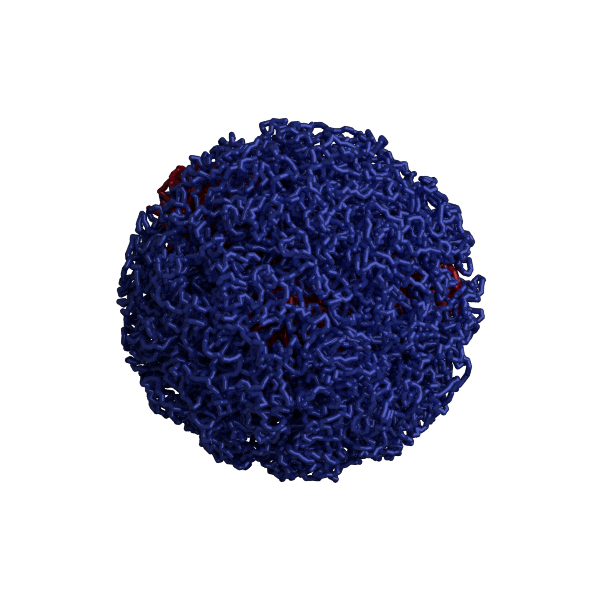

In [38]:
# Visualize new conformation
final_snapshot = system.state.get_snapshot()
render.fresnel(final_snapshot, show="compartments", cmap="coolwarm").static()

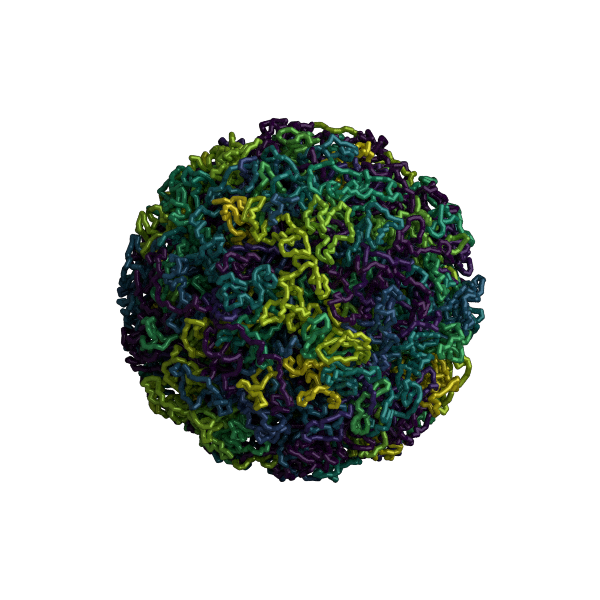

In [39]:
# Visualize individual loops
render.fresnel(final_snapshot, show="loops").static()